## CX4240 project

## Classification of Acute Lymphoblastic Leukemia (ALL) in Blood Cell Images Using Machine Learning

# Classifications


In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.stats as stat
import sklearn.preprocessing as pre
import glob
import mahotas as mt
import pywt
import seaborn as sns
import pandas as pd
import csv 
import matplotlib as mpl
import time

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from mlens.ensemble import SuperLearner
from mlens.metrics import make_scorer


%matplotlib inline


[MLENS] backend: threading


## Load data

In [4]:
train_df = pd.read_csv('Data/RF_train_data.csv')
train = pd.DataFrame.as_matrix(train_df)
test = pd.DataFrame.as_matrix(pd.read_csv('Data/RF_test_data.csv'))
train_data = train[:,2:]
label_train = np.array(train[:,1], dtype=int)
test_data = test[:,2:]
label_test = np.array(test[:,1], dtype=int)
features = list(train_df.columns[2:]) 
print(np.shape(train_data))
print(np.shape(test_data))
n_ALL = 7272
n_hem = 3389
features

(10661, 16)
(1867, 16)


/Users/pdgalonsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/pdgalonsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


['Cell Size',
 'Perimeter',
 'Haralick Difference Entropy',
 'Haralick Contrast',
 'Red Mean',
 'Value Mean',
 'Haralick Information Measures of Correlation 1',
 'Haralick Information Measures of Correlation 2',
 'Hue Mean',
 'Saturation Mean',
 'Haralick Sum Average',
 'Blue Mean',
 'Haralick Correlation',
 'Form Factor',
 'Intensity Mean',
 'Haralick Sum Entropy']

# Classification

In [21]:
def accuracy(label, pred):
    """
    Calculates true positive, false positive, false negative, true negative, and Accuracy
    arg:
        label: Nx1 vector of true label
        pred: Nx1 vector of predicted labels
    return: 
        accuracy
    """
    TP,FP,TN,FN = 0,0,0,0
    for i in range(len(pred)):
        if (pred[i]==1 and label[i]==1):
            TP = TP + 1
        elif (pred[i]==1 and label[i]==0):
            FP = FP + 1
        elif (pred[i]==0 and label[i]==0):
            TN = TN + 1
        elif (pred[i]==0 and label[i]==1):
            FN = FN + 1
        else:
            print('ERROR: Different values')
    print('True Positive:  ',TP)
    print('False Positive: ',FP)
    print('True Negative:  ',TN)
    print('False Negative: ',FN)
    return (TP+TN)/(TP+TN+FP+FN)


def get_errors(prediction, label):
    """
    args:
        label: numpy array of ground truth (1 is positive, 0 is negative)
        prediction: numpy array of prediction
    returns:
        false_positive: integer of occurences of false positives
        false_negative: integer of occurences of false negatives
        true_positive: integer of occurences of true positives
        true_negative: integer of occurences of true negatives
    """
    diff = label - prediction
    false_positive = np.count_nonzero(diff == -1)
    false_negative = np.count_nonzero(diff == 1)
    total_positive = np.sum(label)
    total_negative = int(len(label) - total_positive)
    true_positive = int(total_positive - false_negative)
    true_negative = total_negative - false_positive
    accuracy = np.round((true_positive + true_negative) / 
                                       (total_positive + total_negative), decimals=3)
    recall =  np.round(true_positive / (true_positive + false_positive), decimals=3)
    precision = np.round(true_positive / (true_positive + false_negative), decimals=3)
    
    print('True Positive:  ',true_positive)
    print('False Positive: ',false_positive)
    print('True Negative:  ',true_negative)
    print('False Negative: ',false_negative)
    print('Precision:      ', precision)
    print('Recall:         ',recall )
    print('Accuracy:       ',accuracy)
    return accuracy


def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

## Support Vector Machine (SVM)

In [6]:
# SVM
# Tuning the hyperparameters
param_grid =  {'C': [3,7,10], 'gamma': [.1,1,5,10], 'kernel': ['rbf'], 'probability':[True]}
SV_clf = GridSearchCV(svm.SVC(), param_grid, cv=5)
t0 = time.time()
SV_clf.fit(train_data, label_train)
svc_fit = time.time() - t0
print("SVM gamma and C selected and model fitted in %.2f s"
      % svc_fit)


# save the best hyperparameters
svm_c, svm_gamma = SV_clf.best_estimator_.C, SV_clf.best_estimator_.gamma

print('best score:', SV_clf.best_score_)                               
print('best C value:', svm_c)
print('best gamma value:', svm_gamma)


SVM gamma and C selected and model fitted in 496.54 s
best score: 0.8891285995685207
best C value: 10
best gamma value: 5


/Users/pdgalonsky/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


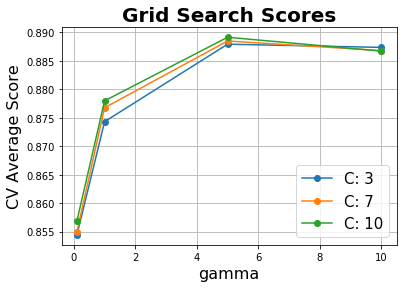

In [20]:
Cs = [3,7,10]
Gammas = [.1,1,5,10]
    
# visualizing gridsearch
plot_grid_search(SV_clf.cv_results_, Gammas, Cs, 'gamma', 'C')


In [7]:
# see how it works on the training data
print('SVM Results')
print('-------------------------')
print('Training Data:')
train_predictions = SV_clf.predict(train_data)
get_errors(train_predictions, label_train)


# see how it works on the test data
print(' ')
print('Test Data:')
test_predictions = SV_clf.predict(test_data)
SVM_accuracy = get_errors(test_predictions, label_test)

accuracies = [SVM_accuracy]

SVM Results
-------------------------
Training Data:
True Positive:   7108
False Positive:  627
True Negative:   2762
False Negative:  164
Precision:       0.977
Recall:          0.919
Accuracy:        0.926
 
Test Data:
True Positive:   1061
False Positive:  338
True Negative:   310
False Negative:  158
Precision:       0.87
Recall:          0.758
Accuracy:        0.734


## Random Forest (RF)

In [12]:
# Tuning the hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
RF_clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
RF_clf.fit(train_data, label_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 42.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [13]:
# print optomized parameters
print(RF_clf.best_estimator_)


# see how it works on the training data
print('RF Results')
print('-------------------------')
print('Training Data:')
train_predictions = RF_clf.predict(train_data)
get_errors(train_predictions, label_train)


# see how it works on the test data
print(' ')
print('Test Data:')
test_predictions = RF_clf.predict(test_data)
RF_accuracy = get_errors(test_predictions, label_test)

accuracies.append(RF_accuracy)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
RF Results
-------------------------
Training Data:
True Positive:   7272
False Positive:  0
True Negative:   3389
False Negative:  0
Precision:       1.0
Recall:          1.0
Accuracy:        1.0
 
Test Data:
True Positive:   1103
False Positive:  394
True Negative:   254
False Negative:  116
Precision:       0.905
Recall:          0.737
Accuracy:        0.727


In [14]:
# more conservative rf
rf2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=75, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# fit
rf2.fit(train_data, label_train)


# see how it works on the training data
print('RF Results')
print('-------------------------')
print('Training Data:')
train_predictions = rf2.predict(train_data)
get_errors(train_predictions, label_train)


# see how it works on the test data
print(' ')
print('Test Data:')
test_predictions = rf2.predict(test_data)
RF2_accuracy = get_errors(test_predictions, label_test)

accuracies.append(RF2_accuracy)

RF Results
-------------------------
Training Data:
True Positive:   7229
False Positive:  325
True Negative:   3064
False Negative:  43
Precision:       0.994
Recall:          0.957
Accuracy:        0.965
 
Test Data:
True Positive:   1115
False Positive:  405
True Negative:   243
False Negative:  104
Precision:       0.915
Recall:          0.734
Accuracy:        0.727


## K Nearest Neighbors

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [24]:
# find best K values using cross validation
def k_fold_test(train_data, train_label, train_index, test_index, k_value):
    KNN = KNeighborsClassifier(n_neighbors = k_value, weights="uniform", algorithm="brute") 
    KNN.fit(train_data[train_index,:], train_label[train_index])
    mean_accuracy_current_fold = KNN.score(train_data[test_index,:], train_label[test_index])
    return mean_accuracy_current_fold

def k_value_use_k_fold(train_data, train_label, k_value, kfold_nsplit):
    all_mean_accuracy = []
    kf = KFold(n_splits = kfold_nsplit, shuffle = False)
    for train_index, test_index in kf.split(train_data):
        mean_accuracy_current_fold = k_fold_test(train_data, train_label, train_index, test_index, k_value)
        all_mean_accuracy.append(mean_accuracy_current_fold)
    average_accuracy = np.round(np.mean(np.array(all_mean_accuracy)), decimals=4)
    print("{} \t {}".format(k_value, average_accuracy))
    return average_accuracy

K val 	 Avg. Accuracy
--------------------------
4 	 0.817
6 	 0.8356
8 	 0.8388
9 	 0.8443
10 	 0.8413
12 	 0.8423
15 	 0.8425
20 	 0.8427
25 	 0.8403
30 	 0.8412
50 	 0.8363
90 	 0.8313
100 	 0.8312
150 	 0.8265
200 	 0.8227


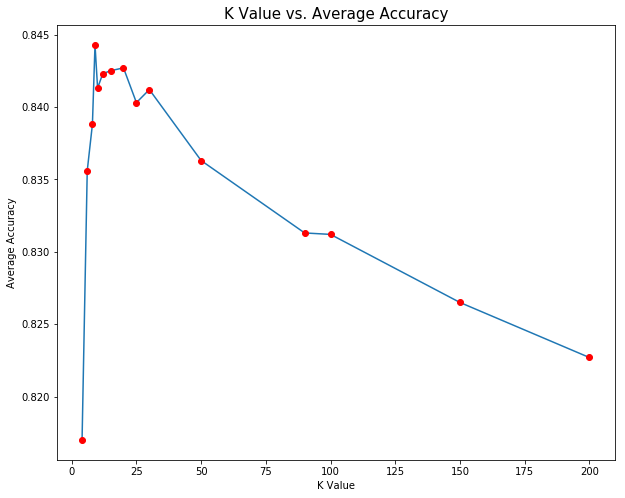

In [25]:
# test the mean accuracy for each k value

number_of_splits = 10
k_value_list = [4,6,8,9,10,12,15,20,25,30, 50, 90, 100, 150, 200]

print('K val \t Avg. Accuracy')
print('--------------------------')
test_tuple_list = []
for k_value in k_value_list:
    average_accuracy = k_value_use_k_fold(train_data, label_train, k_value, number_of_splits)
    test_tuple_list.append((average_accuracy, k_value))
    
x = [x[1] for x in test_tuple_list]
y = [x[0] for x in test_tuple_list]
plt.figure(figsize=(10,8))
plt.plot(x,y)
plt.plot(x,y,'or')
plt.title("K Value vs. Average Accuracy", fontsize=15)
plt.xlabel("K Value", fontsize=10)
plt.ylabel("Average Accuracy", fontsize=10)
plt.show()

test_tuple_list.sort(reverse = True)
best_k_value = test_tuple_list[0][1]

In [26]:
# Use the best K_value

print("Best K Value is {}".format(best_k_value))
print(' ')
KNN_clf = KNeighborsClassifier(n_neighbors = best_k_value, weights="uniform", algorithm="brute")


# train and predict
KNN_clf.fit(train_data, label_train)
KNN_train_pred = KNN_clf.predict(train_data)
KNN_test_pred = KNN_clf.predict(test_data)


# print results
# train results
print('KNN Results')
print('-------------------------')
print('Training Data')
get_errors(KNN_train_pred, label_train)

# test results
print(' ')
print('Test Data')
KNN_accuracy = get_errors(KNN_test_pred, label_test)

accuracies.append(KNN_accuracy)

Best K Value is 9
 
KNN Results
-------------------------
Training Data
True Positive:   7022
False Positive:  907
True Negative:   2482
False Negative:  250
Precision:       0.966
Recall:          0.886
Accuracy:        0.891
 
Test Data
True Positive:   1113
False Positive:  430
True Negative:   218
False Negative:  106
Precision:       0.913
Recall:          0.721
Accuracy:        0.713


## Ensemble

In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#import xgboost as xgb
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score

seed = 2034
np.random.seed(seed)

In [38]:
# here we combine the three models above (SVM, RF and KNN)
# and make a prediction with majority vote

# first create models with the optomizal hyperparameters discerned above
svc = svm.SVC(C=svm_c, gamma=svm_gamma, kernel='rbf', probability=True)
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
knn = KNeighborsClassifier(n_neighbors = best_k_value, weights="uniform", algorithm="brute")

# store the estimators in a list for our voting classifier
ests = [('svc', svc), ('rf', rf), ('knn', knn)]

# create the max-vote classifier
MV_clf = VotingClassifier(estimators=ests, voting='soft')

# train and predict
MV_clf.fit(train_data, label_train)
mv_train_pred = MV_clf.predict(train_data)
mv_test_pred = MV_clf.predict(test_data)


# print results
# train results
print('Max Voting Results')
print('-------------------------')
print('Training Data')
get_errors(mv_train_pred, label_train)

# test results
print(' ')
print('Test Data')
MV_accuracy = get_errors(mv_test_pred, label_test)
accuracies.append(MV_accuracy)


Max Voting Results
-------------------------
Training Data
True Positive:   7183
False Positive:  521
True Negative:   2868
False Negative:  89
Precision:       0.988
Recall:          0.932
Accuracy:        0.943
 
Test Data
True Positive:   1098
False Positive:  389
True Negative:   259
False Negative:  121
Precision:       0.901
Recall:          0.738
Accuracy:        0.727


## Stacking

In [37]:
# here we use SVM, RF and KNN as our base estimators
n_folds = 5
N = train_data.shape[0]
n_ests = 3 # number of base estimators

def generate_fold_ids(train_data, n_folds):
    """
    generate shuffled fold ids for train_data
    args:
        train_data: numpy array of train data
        n_folds: int number of folds
    returns:
        fold_ids: numpy array of fold ids
    """
    foldsize = N // n_folds
    extras = N % n_folds
    fold_ids = []
    for i in range(n_folds):
        fldsz = foldsize
        if extras != 0:
            fldsz += 1
            extras = extras -1
        ad = fldsz * [i]
        fold_ids += ad
    fold_ids = np.array(fold_ids)
    np.random.shuffle(fold_ids)
    return fold_ids

# Partition the training data into five folds
fold_ids = generate_fold_ids(train_data, n_folds)

# initialize our meta data
train_meta = np.zeros((N, n_ests)).astype(int)
test_meta = np.zeros((test_data.shape[0], n_ests)).astype(int)

# go through each fold and train on all the other data
for fold in range(n_folds):
    train_ids = []
    test_ids = []
    for i in range(N):
        # get train and test ids for this fold
        if fold_ids[i] != fold:
            train_ids.append(i)
        elif fold_ids[i] == fold:
            test_ids.append(i)
            
    # train on this fold's training data
    X = train_data[train_ids]
    y = label_train[train_ids]
    
    print('fitting models in fold', fold)
    svc.fit(X, y)
    rf.fit(X, y)
    knn.fit(X, y)
    
    # predict on this fold
    print('making predictions on fold', fold)
    train_meta[test_ids,0] = svc.predict(train_data[test_ids])
    train_meta[test_ids,1] = rf.predict(train_data[test_ids])
    train_meta[test_ids,2] = knn.predict(train_data[test_ids])



fitting models in fold 0
making predictions on fold 0
fitting models in fold 1
making predictions on fold 1
fitting models in fold 2
making predictions on fold 2
fitting models in fold 3
making predictions on fold 3
fitting models in fold 4
making predictions on fold 4


In [33]:
# fit each base model to the entire training set
print('fitting base models to entire training set')
svc.fit(train_data, label_train)
rf.fit(train_data, label_train)
knn.fit(train_data, label_train)

# make predictions on test data
print('classifying test data with base models')
test_meta[:,0] = svc.predict(test_data)
test_meta[:,1] = rf.predict(test_data)
test_meta[:,2] = knn.predict(test_data)



fitting base models to entire training set
classifying test data with base models


In [34]:
# Tuning the hyperparameters
param_grid =  {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 20), 'solver' : ['liblinear']}
reg = LogisticRegression()
stack_clf = GridSearchCV(reg, param_grid, cv=5, verbose=True)

# Fit on data
stack_clf.fit(train_meta, label_train)

#print our best meta classifier
print(stack_clf.best_estimator_)

s_train_pred = stack_clf.predict(train_meta)
s_test_pred = stack_clf.predict(test_meta)

# print results
# train results
print('Stacking Results')
print('-------------------------')
print('Training Data')
get_errors(s_train_pred, label_train)

# test results
print(' ')
print('Test Data')
s_errors = get_errors(s_test_pred, label_test)
accuracies.append(s_errors)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=0.0006951927961775605, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Stacking Results
-------------------------
Training Data
True Positive:   7103
False Positive:  983
True Negative:   2406
False Negative:  169
Precision:       0.977
Recall:          0.878
Accuracy:        0.892
 
Test Data
True Positive:   1129
False Positive:  419
True Negative:   229
False Negative:  90
Precision:       0.926
Recall:          0.729
Accuracy:        0.727


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.3s finished


0.727

### ROC Curve

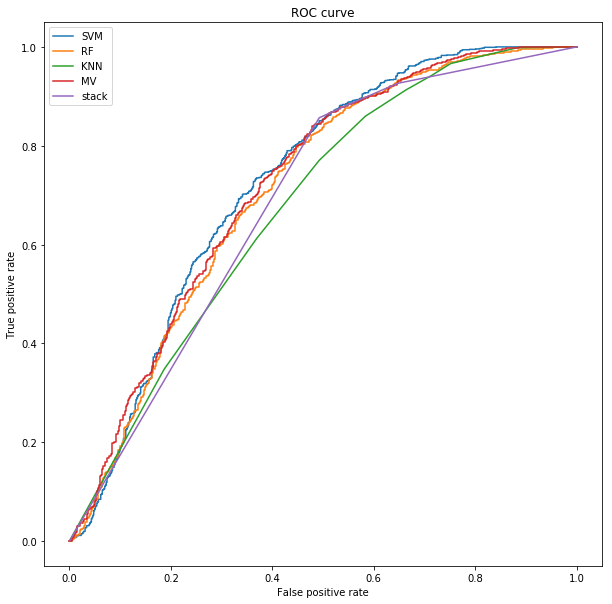

In [35]:
from sklearn.metrics import roc_curve

# get the roc curve for each model
SVM_prob = SV_clf.predict_proba(test_data)[:,1]
FPR_SVM, TPR_SVM, _ = roc_curve(label_test, SVM_prob)
RF_prob = rf2.predict_proba(test_data)[:,1]
FPR_RF, TPR_RF, _ = roc_curve(label_test, RF_prob)
KNN_prob = KNN_clf.predict_proba(test_data)[:,1]
FPR_KNN, TPR_KNN, _ = roc_curve(label_test, KNN_prob)
MV_prob = MV_clf.predict_proba(test_data)[:,1]
FPR_MV, TPR_MV, _ = roc_curve(label_test, MV_prob)
stack_prob = stack_clf.predict_proba(test_meta)[:,1]
FPR_stack, TPR_stack, _ = roc_curve(label_test, stack_prob)


# plot the roc curves for each model
plt.figure(1, figsize = (10,10))
plt.plot(FPR_SVM, TPR_SVM, label='SVM')
plt.plot(FPR_RF, TPR_RF, label='RF')
plt.plot(FPR_KNN, TPR_KNN, label='KNN')
plt.plot(FPR_MV, TPR_MV, label='MV')
plt.plot(FPR_stack, TPR_stack, label='stack')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

No handles with labels found to put in legend.


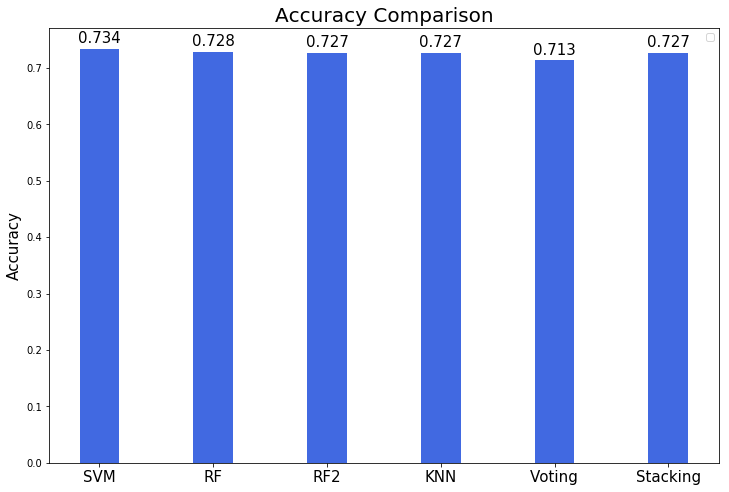

In [39]:
# Plot accuracies

models = ['SVM', 'RF', 'RF2', 'KNN', 'Voting', 'Stacking']
x = np.arange(len(models))
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 8))
rects = ax.bar(x, accuracies, width, color='royalblue')
ax.set_title("Accuracy Comparison", fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=15)
ax.legend()
for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
              xy=(rect.get_x() + rect.get_width() / 2, height),
              xytext=(0, 3),  
              textcoords="offset points",
              ha='center', va='bottom',fontsize = 15)